### Data Preparation Steps

1. **Download Data:**
   - Download the 'POS_Kel_num_agg_merged.csv' file from the Kellanova team's Git repository. Ensure it is located in the same directory as this notebook.

2. **Upload CSV File:**
   - Upload the CSV file to the current directory where this notebook is located.

3. **Download Models:**
   - Download the following models and place them in the same directory as this notebook:
     - 'Kel_POS_base_model.h5'
     - 'KEL_POS_lstm_model.h5'

4. **Run the Following Cells:**
   - Execute the cells below to perform further analysis and visualization on the data, and later on to evaluate the models' results.


In [1]:
import pandas as pd
full_data=pd.read_csv('POS_Kel_num_agg_merged.csv')

In [2]:
full_data=full_data.drop(columns=['REF_AREA'])

In [3]:
full_data['Difference'] = full_data['Actl Ship Usd'] - full_data['Pln Ship Usd']

In [4]:
exclude_cols=['Month', 'year', 'period', 'WK', 'Yr & Wk', 'Cal Wk']
full_data_numeric=full_data.apply(lambda x: pd.to_numeric(x, errors='ignore') if x.name not in exclude_cols else x)

for column in full_data_numeric.columns:
    if full_data_numeric[column].dtype=='object':
        full_data_numeric[column]=pd.factorize(full_data_numeric[column])[0]

#correlations = full_data_numeric.corr()['Actl Ship Usd'].drop('Actl Ship Usd')
#sorted_correlations = correlations.abs().sort_values(ascending=False)

### Overall Baseline

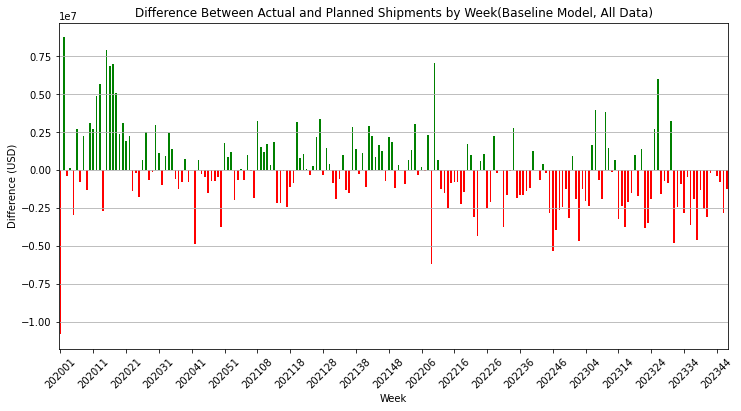

Average Difference (Baseline Model, All Data): -141485.26 USD
RMSE (Baseline Model, All Data): 82838.51 USD


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
weekly_difference=full_data_numeric.groupby('Cal Wk')['Difference'].sum()
plt.figure(figsize=(12, 6))
colors = ['green' if diff>= 0 else 'red' for diff in weekly_difference]
weekly_difference.plot(kind='bar', color=colors)
plt.title('Difference Between Actual and Planned Shipments by Week(Baseline Model, All Data)')
plt.xlabel('Week')
plt.ylabel('Difference (USD)')
plt.xticks(range(0, len(weekly_difference), 10), weekly_difference.index[::10], rotation=45)
plt.grid(axis='y')
plt.show()

avg_difference=weekly_difference.mean()
rmse=np.sqrt(np.mean((full_data_numeric['Difference'])**2))
print(f"Average Difference (Baseline Model, All Data): {avg_difference:.2f} USD")
print(f"RMSE (Baseline Model, All Data): {rmse:.2f} USD")

In [7]:
le_actl=['Act Sc Prxy Usd', 'Actl Cost Of Prod Usd',
       'Actl Ship Cs', 'Actl Ship Kg', 'Actl Ship Lbs', 'Actl Ship Units',
       'Actl Ship Usd','Act Nsv Prxy Usd','Latst Estmt Cost Of Prod Usd', 'Latst Estmt Cost Of Prod Usd Fxd',
       'Latst Estmt Gsv', 'Latst Estmt Kmf Usd', 'Latst Estmt Nsv Prxy Usd',
       'Latst Estmt Sc Prxy Usd', 'Latst Estmt Sc Prxy Usd Gsv',
       'Latst Estmt Ship Lbs', 'Latst Estmt Ship Units', 'Le Cop Fixed',
       'Le Cs', 'Le Kgs']

In [8]:
selected_columns = ['Month', 'year', 'period', 'Pln Base Cs', 'Pln Base Lbs', 'Pln Base Rtn Usd','Pln Base Units', 'Pln Base Usd', 'Pln Cons Lbs', 'Pln Cons Rtn Usd',
       'Pln Cons Units', 'Pln Cons Usd', 'Pln Inc Usd', 'Pln Incr Cs',
       'Pln Incr Lbs', 'Pln Incr Rtn Usd', 'Pln Incr Ship Cs',
       'Pln Incr Ship Kgs', 'Pln Incr Ship Lbs', 'Pln Incr Ship Units',
       'Pln Incr Ship Usd', 'Pln Incr Units', 'Pln Kmf', 'Pln Nsv Prxy Usd',
       'Pln Sc Prxy Usd', 'Pln Ship Cs', 'Pln Ship Ea', 'Pln Ship Kg',
       'Pln Ship Lbs', 'Pln Ship Usd', 'Sugstd Base Vol Sas',
       'Sugstd Shlf Prc Sas', 'Totl Pln Kmf Cost Of Prod Usd', 'Cal Wk',
       'Fisc Yr', 'Matrl', 'Mixd Plt Matrl', 'Mixd Plt Matrl Desc', 'Pd Yr',
       'Pln To Nbr', 'Prod Hier Brand', 'Prod Hier Typ', 'Prod Hier Typ Desc',
       'QTR', 'SZ', 'WK','Bananas, per lb.', 'Oranges, Navel, per lb.',
       'Bread, white, pan, per lb.', 'Tomatoes, field grown, per lb.',
       'Chicken, fresh, whole, per lb.', 'Electricity per KWH',
       'Eggs, grade A, large, per doz.',
       'Gasoline, unleaded regular, per gallon',
       'Ground chuck, 100% beef, per lb.', 'Utility (piped) gas per therm',
       'Milk, fresh, whole, fortified, per gal.', '       value_FarmProducts',
       '       value_ProcessedFoods', '       value', 'TIME_PERIOD',
       'Food and non-alcoholic beverages', 'Housing', 'Total',
       'Food and non-alcoholic beverages - Percent Change 1 month',
       'Food and non-alcoholic beverages - Percent Change 3 month',
       'Food and non-alcoholic beverages - Percent Change 6 month',
       'Food and non-alcoholic beverages - Percent Change 1yr',
       'Housing - Percent Change 1 month', 'Housing - Percent Change 3 month',
       'Housing - Percent Change 6 month', 'Housing - Percent Change 1yr',
       'Total - Percent Change 1 month', 'Total - Percent Change 3 month',
       'Total - Percent Change 6 month', 'Total - Percent Change 1yr',
       'Difference']

In [9]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import LearningRateScheduler 

In [10]:
X=full_data_numeric[selected_columns].values
y=full_data_numeric['Actl Ship Usd'].values
train_size=int(len(X) * 0.8)
train_X, test_X=X[:train_size, :], X[train_size:, :]
train_y, test_y=y[:train_size], y[train_size:]
scaler_X=StandardScaler()
scaler_y=StandardScaler()
train_X_scaled=scaler_X.fit_transform(train_X)
train_y_scaled=scaler_y.fit_transform(train_y.reshape(-1, 1))
train_X_reshaped=np.reshape(train_X_scaled, (train_X_scaled.shape[0], 1, train_X_scaled.shape[1]))

In [11]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

In [12]:
#Load models
base_model=load_model('Kel_POS_base_model.h5')
lstm_model=load_model('KEL_POS_lstm_model.h5')

#Base model
test_data=full_data_numeric[train_size:]
test_X_scaled=scaler_X.transform(test_X)
test_X_reshaped=np.reshape(test_X_scaled, (test_X_scaled.shape[0], 1, test_X_scaled.shape[1]))
predicted_scaled_base=base_model.predict(test_X_reshaped)
predicted_base=scaler_y.inverse_transform(predicted_scaled_base)

#LSTM model
predicted_scaled_lstm=lstm_model.predict(test_X_reshaped)
predicted_lstm=scaler_y.inverse_transform(predicted_scaled_lstm)

In [13]:
#Result DataFrame for Base Model
result_df_base=pd.DataFrame()
result_df_base['Cal Wk']=test_data['Cal Wk']
result_df_base['Predicted']=predicted_base.flatten()
result_df_base['Actual']=test_y
result_df_base['Predicted_Difference']=result_df_base['Actual'] - result_df_base['Predicted']
result_df_base['Planned_Difference']=result_df_base['Actual'] - test_data['Pln Ship Usd']
result_df_base=result_df_base.sort_values(by='Cal Wk')

#Result DataFrame for LSTM Model
result_df_lstm=pd.DataFrame()
result_df_lstm['Cal Wk']=test_data['Cal Wk']
result_df_lstm['Predicted']=predicted_lstm.flatten()
result_df_lstm['Actual']=test_y
result_df_lstm['Predicted_Difference']=result_df_lstm['Actual'] - result_df_lstm['Predicted']
result_df_lstm['Planned_Difference']=result_df_lstm['Actual'] - test_data['Pln Ship Usd']
result_df_lstm=result_df_lstm.sort_values(by='Cal Wk')

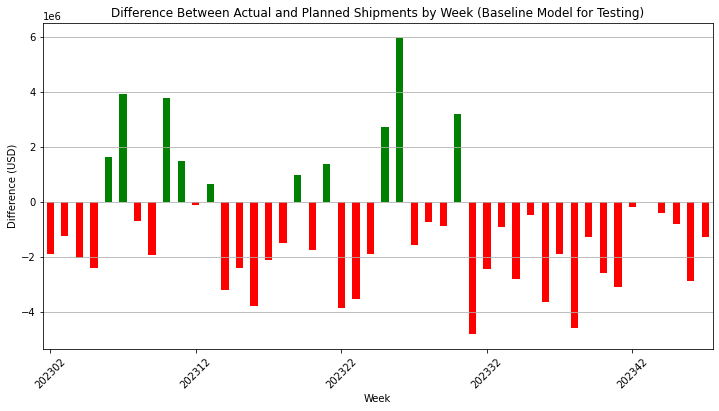

Average Difference (Baseline Model for Testing): -1002033.70 USD
RMSE (Baseline Model for Testing): 84786.48 USD


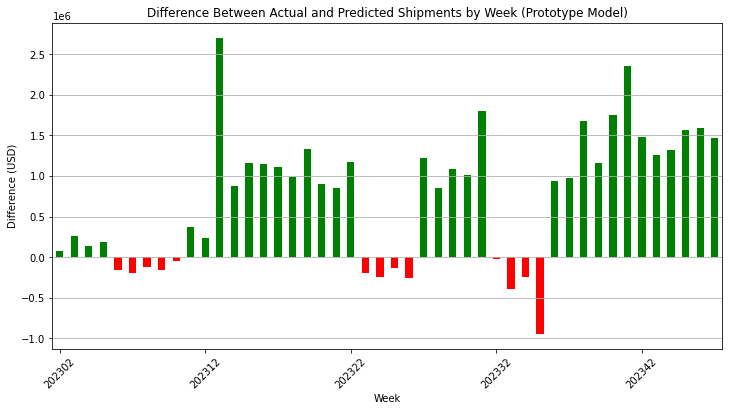

Average Difference (Prototype Model): 737287.25 USD
RMSE (Prototype Model): 42682.80 USD


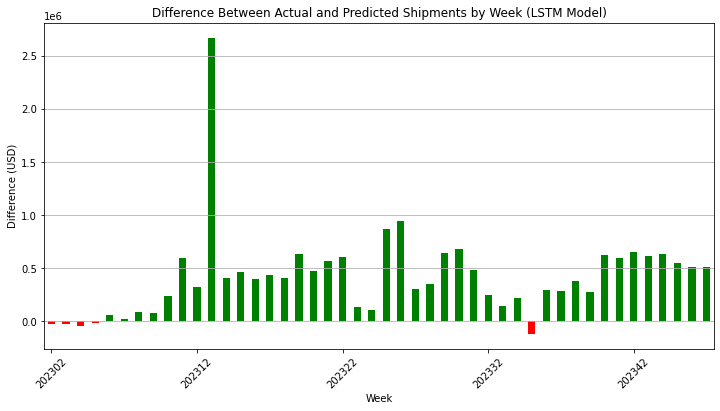

Average Difference (LSTM Model): 420266.69 USD
RMSE (LSTM Model): 29992.56 USD


In [14]:
#Plotting Baseline Model for Testing Set
weekly_difference_lstm=result_df_lstm.groupby('Cal Wk')['Planned_Difference'].sum()
plt.figure(figsize=(12, 6))
colors_lstm=['green' if diff >= 0 else 'red' for diff in weekly_difference_lstm]
weekly_difference_lstm.plot(kind='bar', color=colors_lstm)
plt.title('Difference Between Actual and Planned Shipments by Week (Baseline Model for Testing)')
plt.xlabel('Week')
plt.ylabel('Difference (USD)')
plt.xticks(range(0, len(weekly_difference_lstm), 10), weekly_difference_lstm.index[::10], rotation=45)
plt.grid(axis='y')
plt.show()
avg_difference_lstm=weekly_difference_lstm.mean()
rmse_lstm=np.sqrt(np.mean((result_df_lstm['Planned_Difference'])**2))
print(f"Average Difference (Baseline Model for Testing): {avg_difference_lstm:.2f} USD")
print(f"RMSE (Baseline Model for Testing): {rmse_lstm:.2f} USD")

#Plotting for Prototype Model
weekly_difference_base=result_df_base.groupby('Cal Wk')['Predicted_Difference'].sum()
plt.figure(figsize=(12, 6))
colors_base=['green' if diff >= 0 else 'red' for diff in weekly_difference_base]
weekly_difference_base.plot(kind='bar', color=colors_base)
plt.title('Difference Between Actual and Predicted Shipments by Week (Prototype Model)')
plt.xlabel('Week')
plt.ylabel('Difference (USD)')
plt.xticks(range(0, len(weekly_difference_base), 10), weekly_difference_base.index[::10], rotation=45)
plt.grid(axis='y')
plt.show()
avg_difference_base=weekly_difference_base.mean()
rmse_base=np.sqrt(np.mean((result_df_base['Predicted_Difference'])**2))
print(f"Average Difference (Prototype Model): {avg_difference_base:.2f} USD")
print(f"RMSE (Prototype Model): {rmse_base:.2f} USD")

#Plotting for LSTM Model
weekly_difference_lstm=result_df_lstm.groupby('Cal Wk')['Predicted_Difference'].sum()
plt.figure(figsize=(12, 6))
colors_lstm=['green' if diff >= 0 else 'red' for diff in weekly_difference_lstm]
weekly_difference_lstm.plot(kind='bar', color=colors_lstm)
plt.title('Difference Between Actual and Predicted Shipments by Week (LSTM Model)')
plt.xlabel('Week')
plt.ylabel('Difference (USD)')
plt.xticks(range(0, len(weekly_difference_lstm), 10), weekly_difference_lstm.index[::10], rotation=45)
plt.grid(axis='y')
plt.show()
avg_difference_lstm=weekly_difference_lstm.mean()
rmse_lstm=np.sqrt(np.mean((result_df_lstm['Predicted_Difference'])**2))
print(f"Average Difference (LSTM Model): {avg_difference_lstm:.2f} USD")
print(f"RMSE (LSTM Model): {rmse_lstm:.2f} USD")

## Analysis of Results

### Baseline Model Performance:

- **Average Difference (All Data):** -141,485.26 USD
- **Root Mean Squared Error (RMSE) (All Data):** 82,838.51 USD

- **Average Difference (Testing Data):** -1,002,033.70 USD
- **RMSE (Testing Data):** 84,786.48 USD

### Prototype Model Performance:

- **Average Difference:** 737,287.25 USD
- **RMSE:** 42,682.80 USD

### LSTM Model Performance:

- **Average Difference:** 420,266.69 USD
- **RMSE:** 29,992.56 USD

## Observations:

1. **Baseline Model:**
   - The model shows significant variation in performance between the training and testing datasets, indicating potential overfitting.
   - The average difference in predictions suggests a negative bias, implying the model tends to underestimate.
   - The RMSE on the testing dataset is relatively high, indicating considerable errors in prediction.

2. **Prototype Model:**
   - The prototype model demonstrates a considerable average difference and RMSE.
   - It seems to perform better than the baseline model, as indicated by the smaller RMSE.
   - However, further analysis is needed to understand its generalization capabilities and robustness across different datasets.

3. **LSTM Model:**
   - The LSTM model outperforms both the baseline and prototype models.
   - It exhibits the lowest average difference and RMSE, indicating superior predictive accuracy.
   - This suggests that the LSTM model captures more complex patterns and dependencies in the data, leading to more accurate predictions.

Overall, while the baseline model provides a starting point, both the prototype and LSTM models show promise in improving predictive accuracy, with the LSTM model being the most promising among them.
